In [7]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Download NLTK resources (only needs to be run once)
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")

# Load CSV file
df = pd.read_csv("../data/post_comments.csv")

# Remove empty comments
df = df[df["text"].notna()]

# Convert timestamp column to datetime
df["createTimeISO"] = pd.to_datetime(df["createTimeISO"])

[nltk_data] Downloading package punkt to C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Surface/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Filtering and outliers

In [8]:
# Filter to last 6 months
from datetime import datetime
six_months_ago = pd.Timestamp(datetime.today() - pd.DateOffset(months=6), tz="UTC")
df = df[df["createTimeISO"] >= six_months_ago]

# Remove very long comments (e.g. spam or repeated text blocks)
df = df[df["text"].str.split().str.len() < 100]

# Remove comments with excessive repetition of a single word
def has_repeated_word(text, threshold=5):
    words = text.lower().split()
    word_counts = Counter(words)
    return any(count >= threshold for count in word_counts.values())

df = df[~df["text"].apply(has_repeated_word)]

Stopwords and tokenization

In [9]:
# Define standard and custom stopwords
standard_stopwords = set(stopwords.words("german")) | set(stopwords.words("english"))
custom_stopwords = {
    "use", "like", "get", "need", "please", "one", "would", "watch", "want", "que"
}

# Unigram-specific stopwords (standard + custom)
unigram_stopwords = standard_stopwords | custom_stopwords

# Clean + tokenize for unigram analysis
def clean_tokens_unigrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in unigram_stopwords and len(w) > 2]

# Clean + tokenize for n-gram analysis (no custom stopwords)
def clean_tokens_ngrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in standard_stopwords and len(w) > 2]

# Apply both tokenizations
df["unigram_tokens"] = df["text"].apply(clean_tokens_unigrams)
df["ngram_tokens"] = df["text"].apply(clean_tokens_ngrams)


Most common words

In [10]:
all_unigrams = [word for tokens in df["unigram_tokens"] for word in tokens]
common_unigrams = Counter(all_unigrams).most_common(20)

print("Top 20 unigrams:")
for word, count in common_unigrams:
    print(f"{word}: {count}")

Top 20 unigrams:
skin: 6822
love: 3724
skincare: 2711
face: 1922
good: 1865
acne: 1536
routine: 1501
products: 1481
serum: 1272
girl: 1215
care: 1171
much: 1170
beautiful: 1121
oil: 1096
toner: 1061
aku: 1051
cleanser: 1043
omg: 1000
cream: 980
pretty: 980


Most common bigrams

In [11]:
all_bigrams = [bigram for tokens in df["ngram_tokens"] for bigram in ngrams(tokens, 2)]
common_bigrams = Counter([" ".join(b) for b in all_bigrams]).most_common(20)

print("\nTop 20 bigrams:")
for phrase, count in common_bigrams:
    print(f"{phrase}: {count}")


Top 20 bigrams:
skin care: 806
skincare routine: 349
cleansing oil: 335
cleaning fyp: 314
look like: 312
oily skin: 307
sensitive skin: 282
korean skincare: 270
commenting stay: 269
dry skin: 256
acne prone: 224
oil cleanser: 212
skin type: 203
skin looks: 195
get rid: 189
wash face: 189
care routine: 181
looks like: 179
feel like: 178
prone skin: 170


Most common trigrams

In [12]:
all_trigrams = [tg for tokens in df["ngram_tokens"] for tg in ngrams(tokens, 3)]
common_trigrams = Counter([" ".join(tg) for tg in all_trigrams]).most_common(20)

print("\nTop 20 Trigrams:")
for phrase, count in common_trigrams:
    print(f"{phrase}: {count}")


Top 20 Trigrams:
acne prone skin: 158
skin care routine: 141
instagram sagajewels official: 72
korean skin care: 70
would anyone watch: 69
anua cleansing oil: 65
anyone watch grwm: 61
oily acne prone: 60
izin ambil post: 55
skin looks amazing: 54
speed made famous: 47
fungal acne safe: 46
good oily skin: 45
commenting stay wonyoungism: 45
commenting stay side: 44
stay side tiktok: 38
skin care products: 37
glow recipe toner: 34
commenting stay cleantok: 34
get rid acne: 33


Word explanation

"izin ambil post" is Indonesian and means "Permission to take/use the post."

In [13]:
# Helper function to convert Counter results into DataFrame
def counter_to_df(counter, ngram_type):
    df = pd.DataFrame(counter, columns=["ngram", "count"])
    df["type"] = ngram_type
    return df

# Create Counter objects
unigram_counter = Counter(all_unigrams).most_common(20)
bigram_counter = Counter([" ".join(bg) for bg in all_bigrams]).most_common(20)
trigram_counter = Counter([" ".join(tg) for tg in all_trigrams]).most_common(20)

# Convert to DataFrames
df_unigrams = counter_to_df(unigram_counter, "unigram")
df_bigrams = counter_to_df(bigram_counter, "bigram")
df_trigrams = counter_to_df(trigram_counter, "trigram")

# Combine all into one table
df_ngrams = pd.concat([df_unigrams, df_bigrams, df_trigrams], ignore_index=True)

# Sort by count if you want (optional)
df_ngrams = df_ngrams.sort_values(by="count", ascending=False)

# Show the overview
print(df_ngrams.head(30))

               ngram  count     type
0               skin   6822  unigram
1               love   3724  unigram
2           skincare   2711  unigram
3               face   1922  unigram
4               good   1865  unigram
5               acne   1536  unigram
6            routine   1501  unigram
7           products   1481  unigram
8              serum   1272  unigram
9               girl   1215  unigram
10              care   1171  unigram
11              much   1170  unigram
12         beautiful   1121  unigram
13               oil   1096  unigram
14             toner   1061  unigram
15               aku   1051  unigram
16          cleanser   1043  unigram
17               omg   1000  unigram
18             cream    980  unigram
19            pretty    980  unigram
20         skin care    806   bigram
21  skincare routine    349   bigram
22     cleansing oil    335   bigram
23      cleaning fyp    314   bigram
24         look like    312   bigram
25         oily skin    307   bigram
2

Keyword explanation (openAI)

In [14]:
#import openai
#import os
#from dotenv import load_dotenv

#load_dotenv()
#openai.api_key = os.getenv("OPENAI_API_KEY")

#from openai import OpenAI

#client = OpenAI(api_key=openai.api_key)

#keywords = [
#    "trop trop trop",
#    "sangat sangat sangat",
#    "skin care routine",
#    "wonyoungism"
#]

#for term in keywords:
#    response = client.chat.completions.create(
#        model="gpt-3.5-turbo",
#        messages=[
#            {"role": "system", "content": "You are a helpful assistant who explains slang and social media terms."},
#            {"role": "user", "content": f"Explain the term '{term}' as it appears in TikTok comments."}
#        ],
#        temperature=0.7
#    )
#    explanation = response.choices[0].message.content
#    print(f"{term}: {explanation}\n")

Trends over time

C:\Users\Surface\AppData\Local\Temp\ipykernel_18212\1536940277.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = pd.to_datetime(df["createTimeISO"]).dt.to_period("W").dt.start_time


<Figure size 1400x600 with 0 Axes>

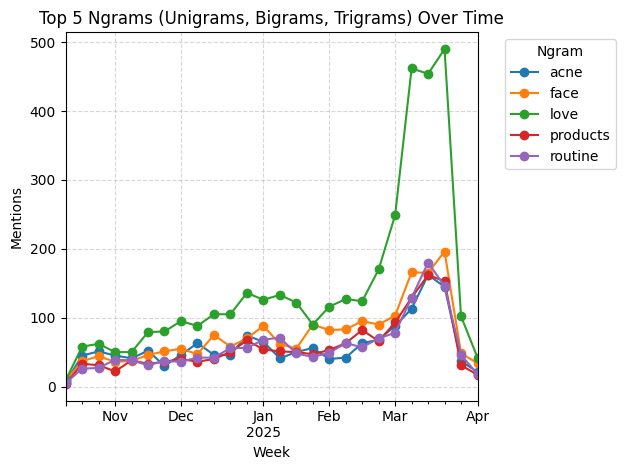

In [15]:
df["week"] = pd.to_datetime(df["createTimeISO"]).dt.to_period("W").dt.start_time

# Combine standard and custom stopwords (only for unigrams)
stop_words = set(stopwords.words("english")) | set(stopwords.words("german"))
custom_stopwords = {"use", "like", "get", "need", "please", "one", "would", "watch", "want", "que", "good", "skin", "skincare"}
unigram_stopwords = stop_words | custom_stopwords

# Clean and tokenize text for unigrams
def tokenize_unigrams(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in unigram_stopwords and len(w) > 2]

# Clean and tokenize text for ngrams
def tokenize_all(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Zäöüß]", " ", text)
    return [w for w in word_tokenize(text) if len(w) > 2]

# Apply both types of tokenization
df["unigrams"] = df["text"].apply(tokenize_unigrams)
df["tokens"] = df["text"].apply(tokenize_all)

# Generate bigrams and trigrams
df["bigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 2)])
df["trigrams"] = df["tokens"].apply(lambda t: [" ".join(g) for g in ngrams(t, 3)])

# Combine into one long format DataFrame: week + ngram
records = []

for _, row in df.iterrows():
    for word in row["unigrams"] + row["bigrams"] + row["trigrams"]:
        records.append((row["week"], word))

df_all = pd.DataFrame(records, columns=["week", "ngram"])

# Count occurrences per week
weekly_counts = df_all.groupby(["week", "ngram"]).size().reset_index(name="count")

# Identify top 5 ngrams overall
top5 = (
    weekly_counts.groupby("ngram")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filter only top 5 for plotting
top_weekly = weekly_counts[weekly_counts["ngram"].isin(top5)]

# Pivot to get ngrams as columns
df_trend = top_weekly.pivot(index="week", columns="ngram", values="count").fillna(0)

# Plot
plt.figure(figsize=(14, 6))
df_trend.plot(marker="o")
plt.title("Top 5 Ngrams (Unigrams, Bigrams, Trigrams) Over Time")
plt.xlabel("Week")
plt.ylabel("Mentions")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Ngram", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

!!! Outliers